<a href="https://colab.research.google.com/github/Prachi729/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Mount Google Drive

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [ ]:
TESS='/content/drive/MyDrive/TESS_combined' # Path to updated dataset

In [ ]:
paths = []
labels = []

# Traverse through the TESS directory to collect audio files and extract emotion labels
for dirname, _, filenames in os.walk(TESS):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())


print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
len(paths)

5550

In [ ]:
paths[:5]

['/content/drive/MyDrive/TESS_combined/YAF_pleasant_surprised/YAF_back_ps.wav',
 '/content/drive/MyDrive/TESS_combined/YAF_pleasant_surprised/YAF_base_ps.wav',
 '/content/drive/MyDrive/TESS_combined/YAF_pleasant_surprised/YAF_bar_ps.wav',
 '/content/drive/MyDrive/TESS_combined/YAF_pleasant_surprised/YAF_bean_ps.wav',
 '/content/drive/MyDrive/TESS_combined/YAF_pleasant_surprised/YAF_beg_ps.wav']

In [ ]:
labels[:5]

['ps', 'ps', 'ps', 'ps', 'ps']

In [ ]:
# Create a DataFrame to organize the audio file paths and corresponding emotion labels
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps
1,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps
2,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps
3,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps
4,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps


In [ ]:
df['label'].value_counts() # Get value counts for 'label' column in df

,count
label,
ps,800
fear,800
sad,800
disgust,800
neutral,800
happy,800
angry,750


<Axes: xlabel='label', ylabel='count'>

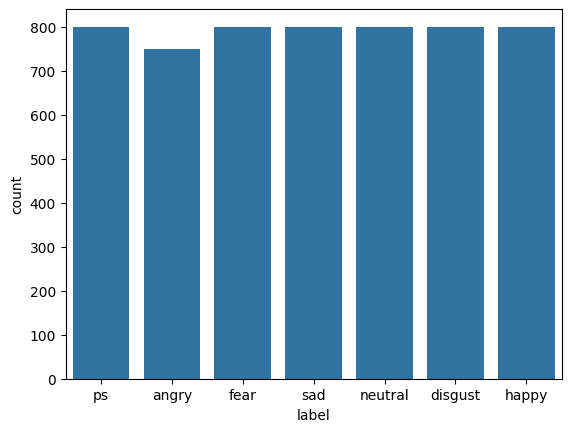

In [ ]:
sns.countplot(data=df, x='label') # Count plot of 'label' column in df

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)  # Plot the audio waveform
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data) # Compute STFT and convert to decibels for spectrogram
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz') # Display the spectrogram
    plt.colorbar()

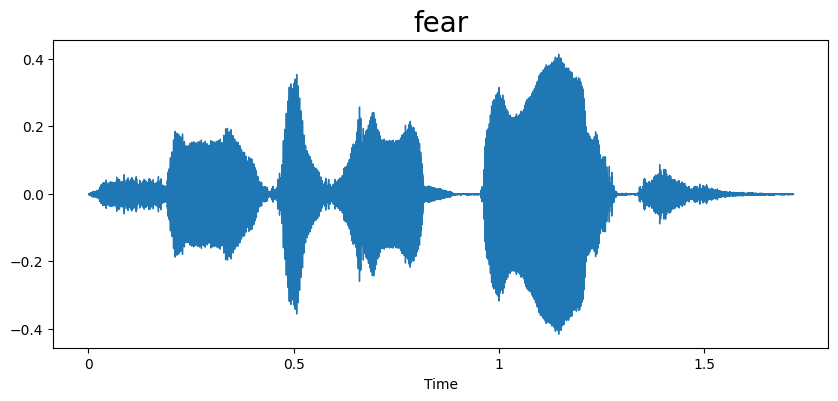

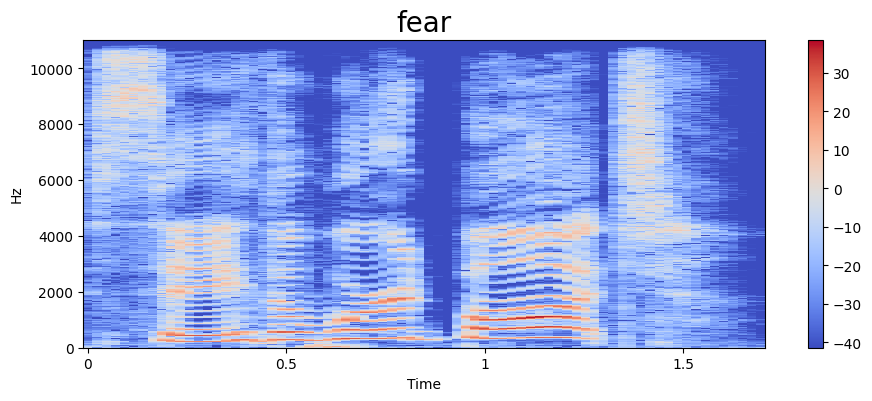

In [ ]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0] # Select one audio file from the dataset with the target emotion
data, sampling_rate = librosa.load(path) # Load the audio file and get its waveform data and sampling rate

# Visualize the waveform and spectrogram for the selected emotion
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)

Audio(path)


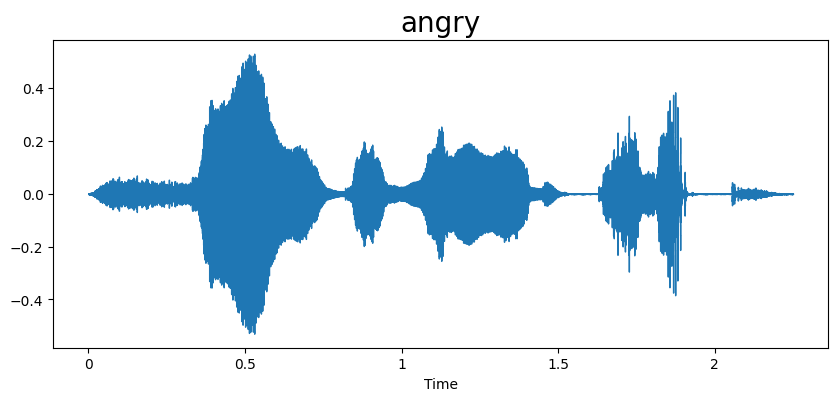

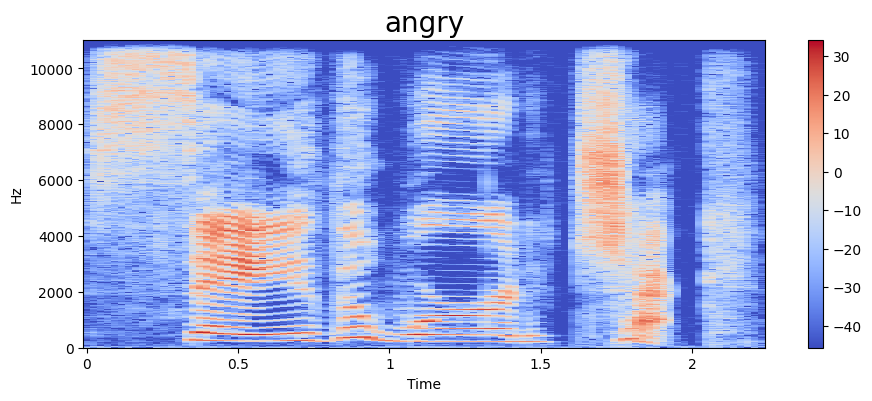

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

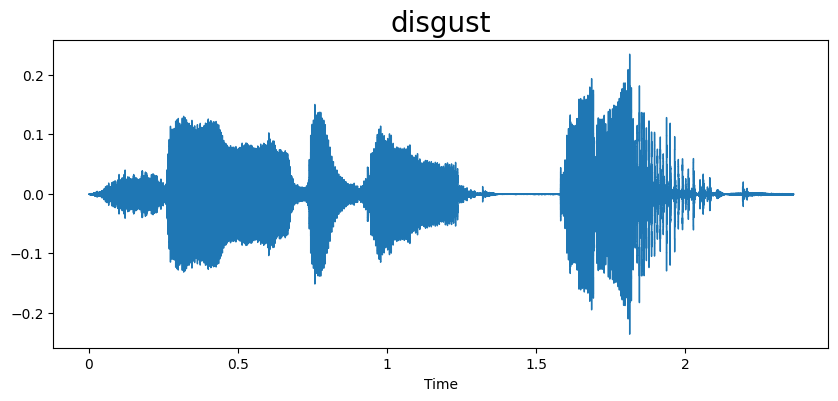

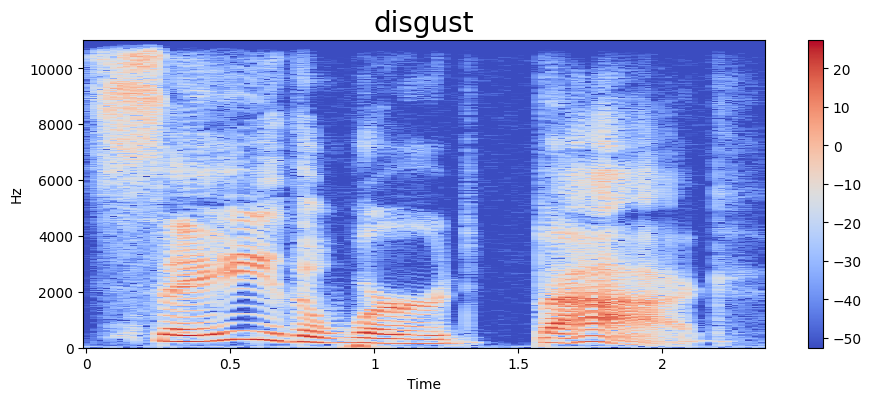

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

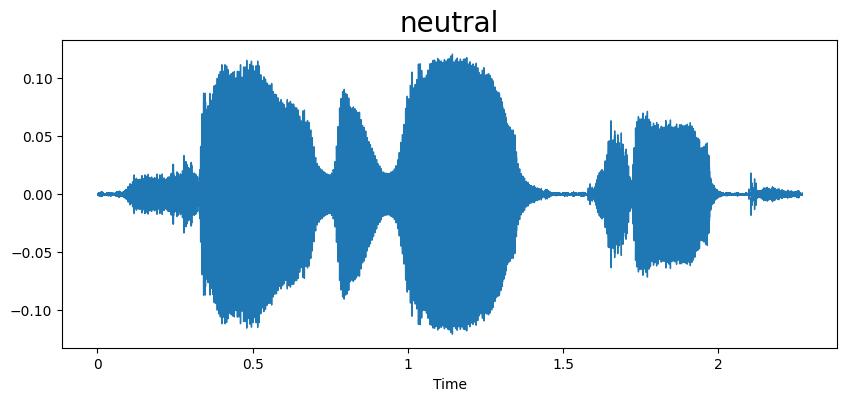

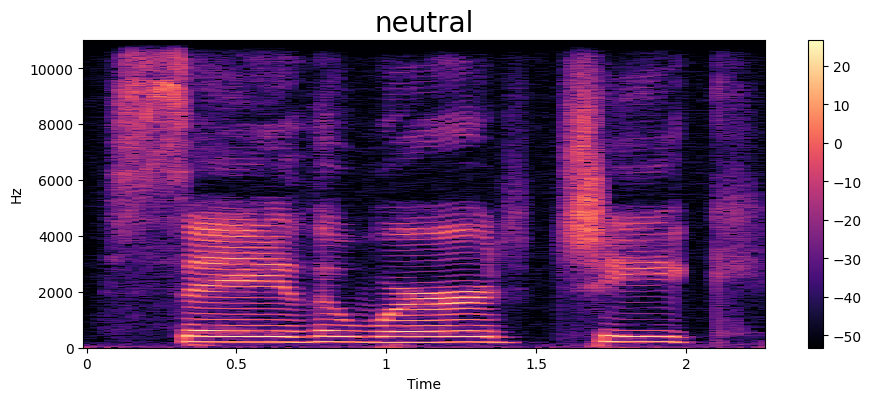

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

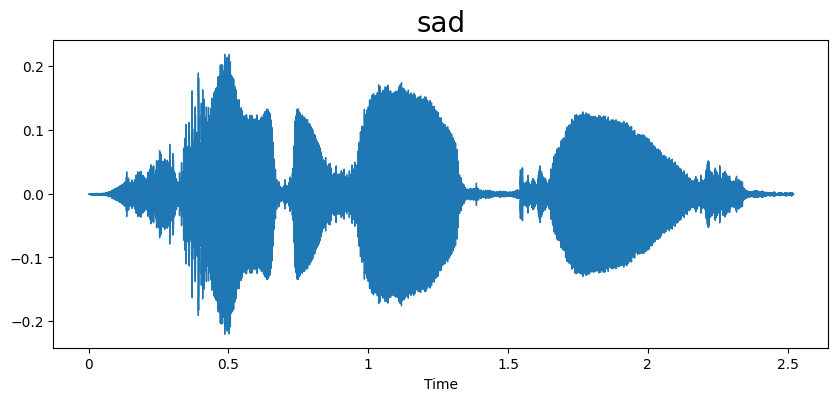

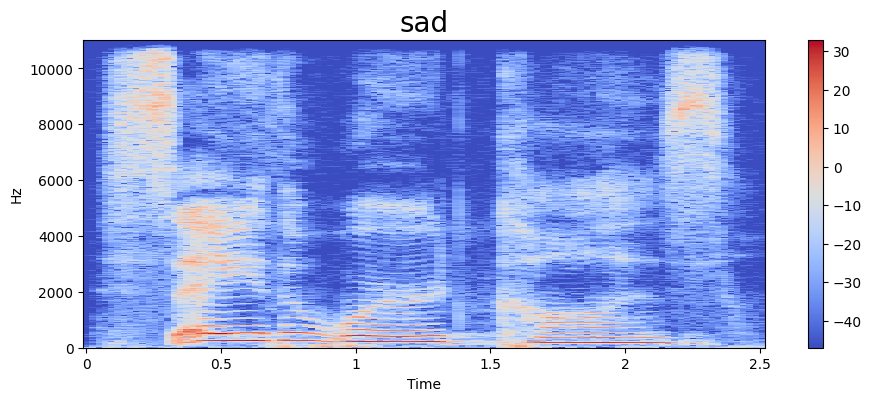

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

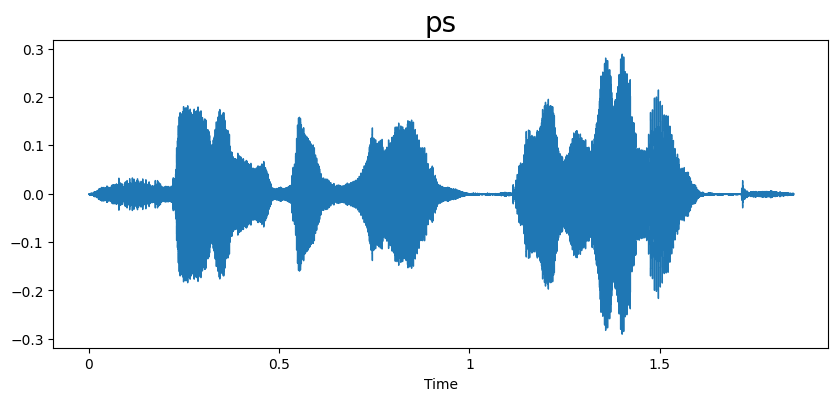

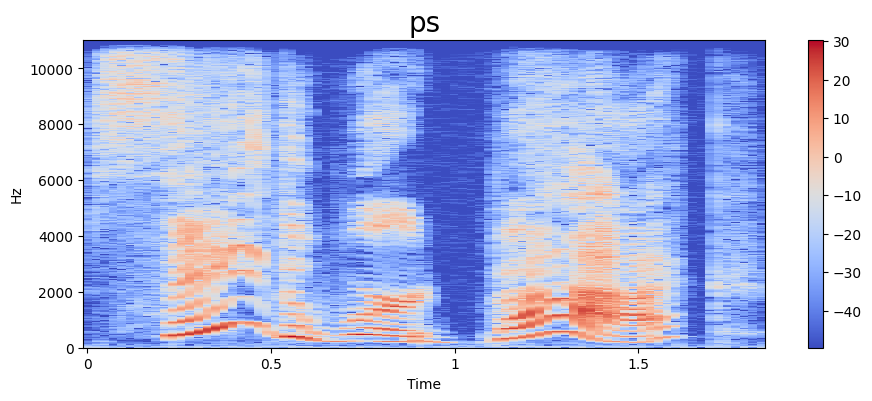

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

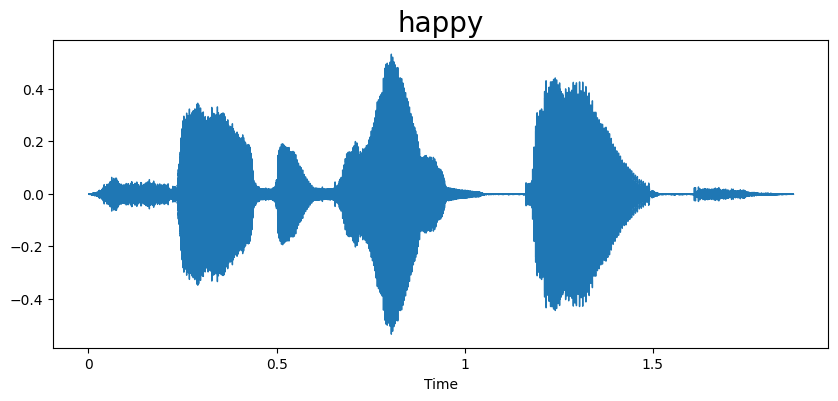

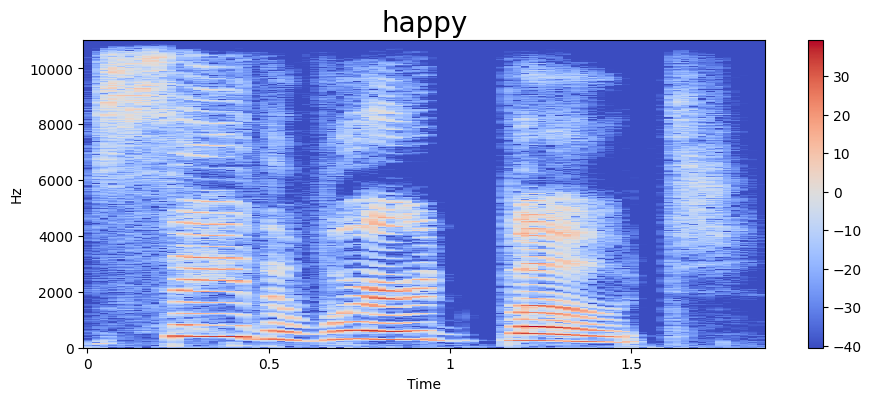

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
# Map emotion labels to numbers and add as new column
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map ={idx:label for label, idx in label_map.items()}
df['labels'] = df['label'].map(label_map)

# Preview first two rows
df.head(2)

,speech,label,labels
0,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps,0
1,/content/drive/MyDrive/TESS_combined/YAF_pleas...,ps,0


In [ ]:
# Custom Dataset class for speech emotion data
class Speech_Emotion_Dataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df                     # DataFrame with file paths and labels
        self.processor = processor       # Feature extractor
        self.max_length = max_length     # Fixed audio length for model

    def __len__(self):
        return len(self.df)     # Number of samples

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['speech']
        label = self.df.iloc[idx]['labels']

        # Load audio file
        speech, sr = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Convert audio to model input tensors
        inputs = self.processor(speech, sampling_rate=sr, return_tensors="pt", padding=True, truncate=True, max_length=self.max_length)
        input_values= inputs.input_values.squeeze()
        return {'input_values':input_values,'labels':torch.tensor(label, dtype=torch.long)}

In [ ]:
from sklearn.model_selection import train_test_split

# Extract speaker ID from audio filename
def get_speaker(file_path):
    return os.path.basename(file_path).split('_')[0]

df['speaker'] = df['speech'].apply(get_speaker)

# Split dataset by speaker to prevent overlap between train and test data
unique_speakers = df['speaker'].unique()
train_speakers, test_speakers = train_test_split(unique_speakers, test_size=0.2, random_state=42)

train_df = df[df['speaker'].isin(train_speakers)]
test_df = df[df['speaker'].isin(test_speakers)]


In [ ]:
# Verify there is no speaker overlap between train and test data
train_speakers = set(train_df['speaker'])
test_speakers = set(test_df['speaker'])
print("Common speakers:", train_speakers.intersection(test_speakers))

Common speakers: set()


In [ ]:
print(len(train_df), len(test_df))



2775 2775


In [ ]:
# Load Wav2Vec2 processor and model for label classification
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Load pretrained model and set number of output labels
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Create Dataset objects for training and testing
train_dataset = Speech_Emotion_Dataset(train_df, processor)
test_dataset = Speech_Emotion_Dataset(test_df, processor)


In [ ]:
train_dataset[0]['input_values'].size()

Keyword argument `truncate` is not a valid argument for this processor and will be ignored.


torch.Size([32000])

In [ ]:
# Create DataLoaders for batching during training and evaluation
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",           # folder to save results
    eval_strategy="epoch",            # evaluate at each epoch
    save_strategy="epoch",            # save model each epoch
    logging_strategy="epoch",         # log after each epoch
    logging_dir="./logs",             # where logs are saved
    report_to="none",                 # disable external loggers
    load_best_model_at_end=True,      # keep best-performing model
    logging_steps=10,                 # log every 10 steps (helps if few batches)
    per_device_train_batch_size=4,    # adjust to your GPU
    per_device_eval_batch_size=4,     # evaluation batch size
    num_train_epochs=3,               # or however many you prefer
    seed=42,                          # reproducibility
)

In [ ]:
# Function to compute evaluation metrics for Hugging Face Trainer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
emotion_labels = ['angry', 'happy', 'sad', 'neutral','fear','disgust','ps']  # adjust to your dataset

printed = False

def compute_metrics(pred):
    global printed
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    # Weighted metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    # Print once: classification report + confusion matrix
    if not printed:
        print("\nEmotion-wise Classification Report:\n")
        print(classification_report(labels, preds, target_names=emotion_labels))

        cm = confusion_matrix(labels, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix for Emotion Predictions")
        plt.show()

        printed = True

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.502500,0.551116,0.903423,0.916726,0.903423,0.903775
2,0.032000,0.120629,0.978378,0.979394,0.978378,0.978418
3,0.001500,0.106190,0.983423,0.983847,0.983423,0.983447



Emotion-wise Classification Report:

              precision    recall  f1-score   support

       angry       0.99      0.98      0.99       400
       happy       1.00      0.93      0.96       375
         sad       0.89      1.00      0.94       400
     neutral       0.83      0.69      0.76       400
        fear       0.72      1.00      0.84       400
     disgust       1.00      0.83      0.91       400
          ps       1.00      0.89      0.94       400

    accuracy                           0.90      2775
   macro avg       0.92      0.90      0.90      2775
weighted avg       0.92      0.90      0.90      2775



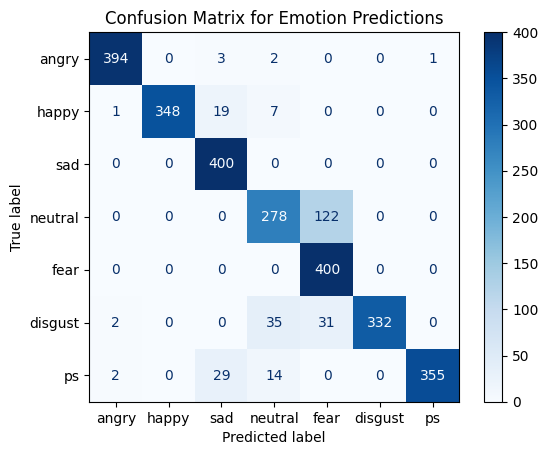

TrainOutput(global_step=2082, training_loss=0.1786529883871161, metrics={'train_runtime': 2524.7878, 'train_samples_per_second': 3.297, 'train_steps_per_second': 0.825, 'total_flos': 1.511612874e+17, 'train_loss': 0.1786529883871161, 'epoch': 3.0})

In [ ]:
# Initialize Hugging Face Trainer and start training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train() # Train the model

In [ ]:
# Evaluate the trained model on the test dataset
print("\nFinal Evaluation on Test Data:\n")
trainer.evaluate()



Final Evaluation on Test Data:



{'eval_loss': 0.1061895340681076,
 'eval_accuracy': 0.9834234234234234,
 'eval_precision': 0.9838470517747644,
 'eval_recall': 0.9834234234234234,
 'eval_f1': 0.9834472041962923,
 'eval_runtime': 42.9001,
 'eval_samples_per_second': 64.685,
 'eval_steps_per_second': 16.177,
 'epoch': 3.0}

In [ ]:
# Visualize sample predictions from test dataset
from IPython.display import Audio, display
import random
import numpy as np
from scipy.special import softmax

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids
true_emotions = [inverse_label_map[label] for label in true_labels]
pred_emotions = [inverse_label_map[label] for label in pred_labels]

# Randomly 10 sample test examples for inspection
num_samples = 10
sample_indices = random.sample(range(len(test_dataset)), num_samples)

print("=== Sample Predictions (True vs. Predicted) ===")
for idx in sample_indices:
    true_emo = true_emotions[idx]
    pred_emo = pred_emotions[idx]
    is_correct = true_emo == pred_emo
    confidence = np.max(softmax(predictions.predictions[idx], axis=0))
    # Access the audio path from the original test_df using the index
    audio_path = test_dataset.df.iloc[idx]['speech']


    status = "✓ Correct" if is_correct else "✗ Wrong"
    print(f"Sample {idx+1}: True={true_emo}, Pred={pred_emo} ({status}, Conf: {confidence:.3f})")
    print(f"Audio: {os.path.basename(audio_path)}")

    print("---")

=== Sample Predictions (True vs. Predicted) ===
Sample 2620: True=happy, Pred=happy (✓ Correct, Conf: 0.999)
Audio: Aug_OAF_dead_happy.wav
---
Sample 457: True=fear, Pred=fear (✓ Correct, Conf: 0.999)
Audio: Aug_YAF_have_fear.wav
---
Sample 103: True=ps, Pred=ps (✓ Correct, Conf: 0.999)
Audio: Aug_YAF_neat_ps.wav
---
Sample 1127: True=ps, Pred=ps (✓ Correct, Conf: 0.999)
Audio: Aug_OAF_perch_ps.wav
---
Sample 1004: True=ps, Pred=ps (✓ Correct, Conf: 0.999)
Audio: Aug_OAF_bar_ps.wav
---
Sample 915: True=sad, Pred=sad (✓ Correct, Conf: 0.999)
Audio: Aug_OAF_near_sad.wav
---
Sample 572: True=fear, Pred=fear (✓ Correct, Conf: 0.999)
Audio: Aug_YAF_thought_fear.wav
---
Sample 420: True=fear, Pred=fear (✓ Correct, Conf: 0.999)
Audio: Aug_YAF_burn_fear.wav
---
Sample 2772: True=happy, Pred=happy (✓ Correct, Conf: 0.999)
Audio: Aug_OAF_when_happy.wav
---
Sample 2234: True=disgust, Pred=sad (✗ Wrong, Conf: 0.990)
Audio: Aug_OAF_hate_disgust.wav
---
